## step1 - import packages

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import operator
import math
import os
import random

# visualizations
import matplotlib.pyplot as plt
import plotly.express as px
from mlxtend.plotting import scatterplotmatrix
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from keras import metrics
from tensorflow import keras
from tensorflow.keras import initializers

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

#classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#for manually define MajorityVoting classifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn.pipeline import Pipeline


c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## step2 - load data

In [2]:
train             = pd.read_csv('./data/icr-identify-age-related-conditions/train.csv')
test              = pd.read_csv('./data/icr-identify-age-related-conditions/test.csv')
greeks            = pd.read_csv('./data/icr-identify-age-related-conditions/greeks.csv')
# submission_df = pd.read_csv('./data/icr-identify-age-related-conditions/sample_submission.csv')

In [3]:
train = train.rename(columns={'Class': 'class_label'})

print('Shape of df wine:', train.shape)
print('Class labels:', train['class_label'].unique())
print()
train.head()

Shape of df wine: (617, 58)
Class labels: [1 0]



,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,class_label
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


## step3 - EDA/preprocessing/split data/standardisation&pca&tsne/imbalanced labels

In [4]:
#summary table

def summary(df):
    print(f'data shape: {df.shape}')
    
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first quartile'] = desc.loc[:, '25%'].values
    summ['second quartile'] = desc.loc[:, '50%'].values
    summ['third quartile'] = desc.loc[:, '75%'].values
    
    return summ

summary(train)

data shape: (617, 58)


,data type,#missing,%missing,#unique,min,max,first quartile,second quartile,third quartile
Id,object,0,0.000000,617,NaN,NaN,NaN,NaN,NaN
AB,float64,0,0.000000,217,0.081187,6.161666,0.252107,0.354659,0.559763
AF,float64,0,0.000000,599,192.59328,28688.18766,2197.34548,3120.31896,4361.63739
AH,float64,0,0.000000,227,85.200147,1910.123198,85.200147,85.200147,113.73954
AM,float64,0,0.000000,605,3.177522,630.51823,12.270314,20.53311,39.139886
AR,float64,0,0.000000,130,8.138688,178.943634,8.138688,8.138688,8.138688
AX,float64,0,0.000000,427,0.699861,38.27088,4.128294,5.031912,6.431634
AY,float64,0,0.000000,148,0.025578,10.315851,0.025578,0.025578,0.036845
AZ,float64,0,0.000000,484,3.396778,38.971568,8.12958,10.46132,12.969516
BC,float64,0,0.000000,259,1.2299,1463.693448,1.2299,1.2299,5.081244


- 56 X variables and 1 target(y) variable:
    - id - NOT relevant for modelling
    - EJ - NOT numeric (ie categorical) feature
    - BQ/CB/CC/DU/EL/FC/FL/FS/GL - missing values (max 9.7%)


In [5]:
#check for missing values 

train[train.isna().any(axis=1)]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,class_label
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416,0
15,07760b4cf3f8,0.666588,3657.78160,304.283751,75.418144,8.138688,12.818973,0.025578,8.167392,1.229900,...,67.872762,0.77720,0.582478,4.102182,72.611063,2218.449060,23.806958,35.843392,0.015231,0
18,0b2cc0b0e6c5,0.269199,1586.67784,85.200147,14.459893,8.138688,4.907886,0.032886,7.007824,3.521028,...,97.303580,2.73702,0.711165,16.362218,72.611063,3597.877440,31.330820,25.444796,0.011000,0
23,0cf6c827b8bb,0.371751,2354.54142,105.030540,5.150311,8.138688,10.409325,0.025578,11.526358,2.754976,...,4.648113,0.49706,0.866944,21.664358,198.469061,5987.708568,32.610844,15.019194,0.136552,0
24,0d1b855c7635,0.158101,3257.64549,138.368592,8.640630,18.385464,4.146012,0.182700,4.099451,7.836220,...,0.173229,1.82323,0.433472,8.311337,72.611063,1884.728169,48.039971,37.160256,21.978000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,f12d8570682a,0.282018,4226.17426,91.392246,13.704225,8.138688,4.916745,0.025578,9.415188,1.229900,...,4.874422,1.76204,0.386061,12.660022,72.611063,2118.717486,20.714807,29.786332,0.069164,0
594,f46e39a96ee9,0.670861,5501.73569,93.822057,6.993026,8.138688,6.511365,0.025578,9.541228,1.229900,...,NaN,0.49706,0.731484,37.310322,143.490662,1849.552461,31.371751,10.043660,NaN,0
602,f955c0ed8895,0.350386,5431.63797,85.200147,11.607556,8.138688,7.565586,0.025578,10.269109,2.393034,...,4.764967,0.49706,0.704392,12.027486,212.210348,9146.473587,17.287766,30.712252,0.171600,0
603,f96e7ca4a16c,0.662315,1704.39874,123.807144,68.353887,8.138688,5.563452,0.104139,6.736838,1.229900,...,5.781491,1.56600,0.067730,12.073996,72.611063,2369.417670,19.367805,25.591400,0.130680,0


### preprocessing - df_train & df_dev (ie train)

In [6]:
#map nominal feature EJ & class label to numerical 0/1 

EJ_mapping = {label: idx for idx, label in enumerate(np.unique(train.EJ))}
train.EJ = train.EJ.map(EJ_mapping)  #EJ_mapping - {'A': 0, 'B': 1}

label_mapping = {label: idx for idx, label in enumerate(np.unique(train.class_label))}
train.class_label = train.class_label.map(label_mapping)  #class_mapping - {0: 0, 1: 1}

print('EJ:', train.EJ.unique(), '\nclass_label:', train.class_label.unique())

EJ: [1 0] 
class_label: [1 0]


In [7]:
#impute 'NaN' using KNNImputer

from sklearn.impute import KNNImputer 

featuresWithNulls = train.columns[train.isnull().any()]
imputer = KNNImputer(n_neighbors=5)

train[featuresWithNulls] = imputer.fit_transform(train[featuresWithNulls])
train.isnull().sum()

Id             0
AB             0
AF             0
AH             0
AM             0
AR             0
AX             0
AY             0
AZ             0
BC             0
BD             0
BN             0
BP             0
BQ             0
BR             0
BZ             0
CB             0
CC             0
CD             0
CF             0
CH             0
CL             0
CR             0
CS             0
CU             0
CW             0
DA             0
DE             0
DF             0
DH             0
DI             0
DL             0
DN             0
DU             0
DV             0
DY             0
EB             0
EE             0
EG             0
EH             0
EJ             0
EL             0
EP             0
EU             0
FC             0
FD             0
FE             0
FI             0
FL             0
FR             0
FS             0
GB             0
GE             0
GF             0
GH             0
GI             0
GL             0
class_label    0
dtype: int64

### split into df_train vs df_dev

In [8]:
#split into train vs val as 9:1

tf.random.set_seed(1)
np.random.seed(1)

df_train = train.sample(frac=.9, random_state=3)  #w headers
df_dev = train.drop(df_train.index)

print(df_train.shape)
print(df_dev.shape)

(555, 58)
(62, 58)


In [9]:
#separate features vs labels (w headers) & X vs Y (wo headers) for df_train & df_dev

#df_train features/X vs labels/Y
features_train = df_train.iloc[:, 1:-1]  #X - 56 feature columns (excl. id & class_label) - w headers
print('features_train: ', features_train.columns.values.tolist())

labels_train = df_train.class_label  #Y - 1 label column (ie class_label)

X_train, y_train = features_train.values, labels_train.values  #X&Y variables - wo headers (ONLY values)
display(X_train)
print(X_train.shape, y_train.shape)


#df_dev features/X vs labels/Y
features_dev = df_dev.iloc[:, 1:-1]  #X - 56 feature columns (excl. id & class_label) - w headers
labels_dev = df_dev.class_label  #Y - 1 label column (ie class_label)

X_dev, y_dev = features_dev.values, labels_dev.values  #X&Y variables - wo headers (ONLY values)
# display(X_dev)
print(X_dev.shape, y_dev.shape)

features_train:  ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']


array([[3.37567000e-01, 1.25066568e+03, 8.52001470e+01, ...,
        2.30590370e+01, 1.01825480e+02, 2.19780000e+01],
       [4.91395000e-01, 2.07395694e+03, 9.03558750e+01, ...,
        2.45325530e+01, 1.37241920e+01, 1.00980000e+01],
       [1.88012000e-01, 2.66306601e+03, 8.52001470e+01, ...,
        3.06089460e+01, 6.66353760e+01, 2.19780000e+01],
       ...,
       [3.24748000e-01, 5.18868207e+03, 8.52001470e+01, ...,
        2.19948310e+01, 3.33009700e+01, 2.19780000e+01],
       [4.14481000e-01, 3.75144407e+03, 8.52001470e+01, ...,
        2.60060690e+01, 2.30656960e+01, 9.63774840e-02],
       [2.82018000e-01, 2.67085115e+03, 1.13896302e+02, ...,
        3.81886230e+01, 3.14889960e+01, 1.47029703e-01]])

(555, 56) (555,)
(62, 56) (62,)


### EDA - df_train

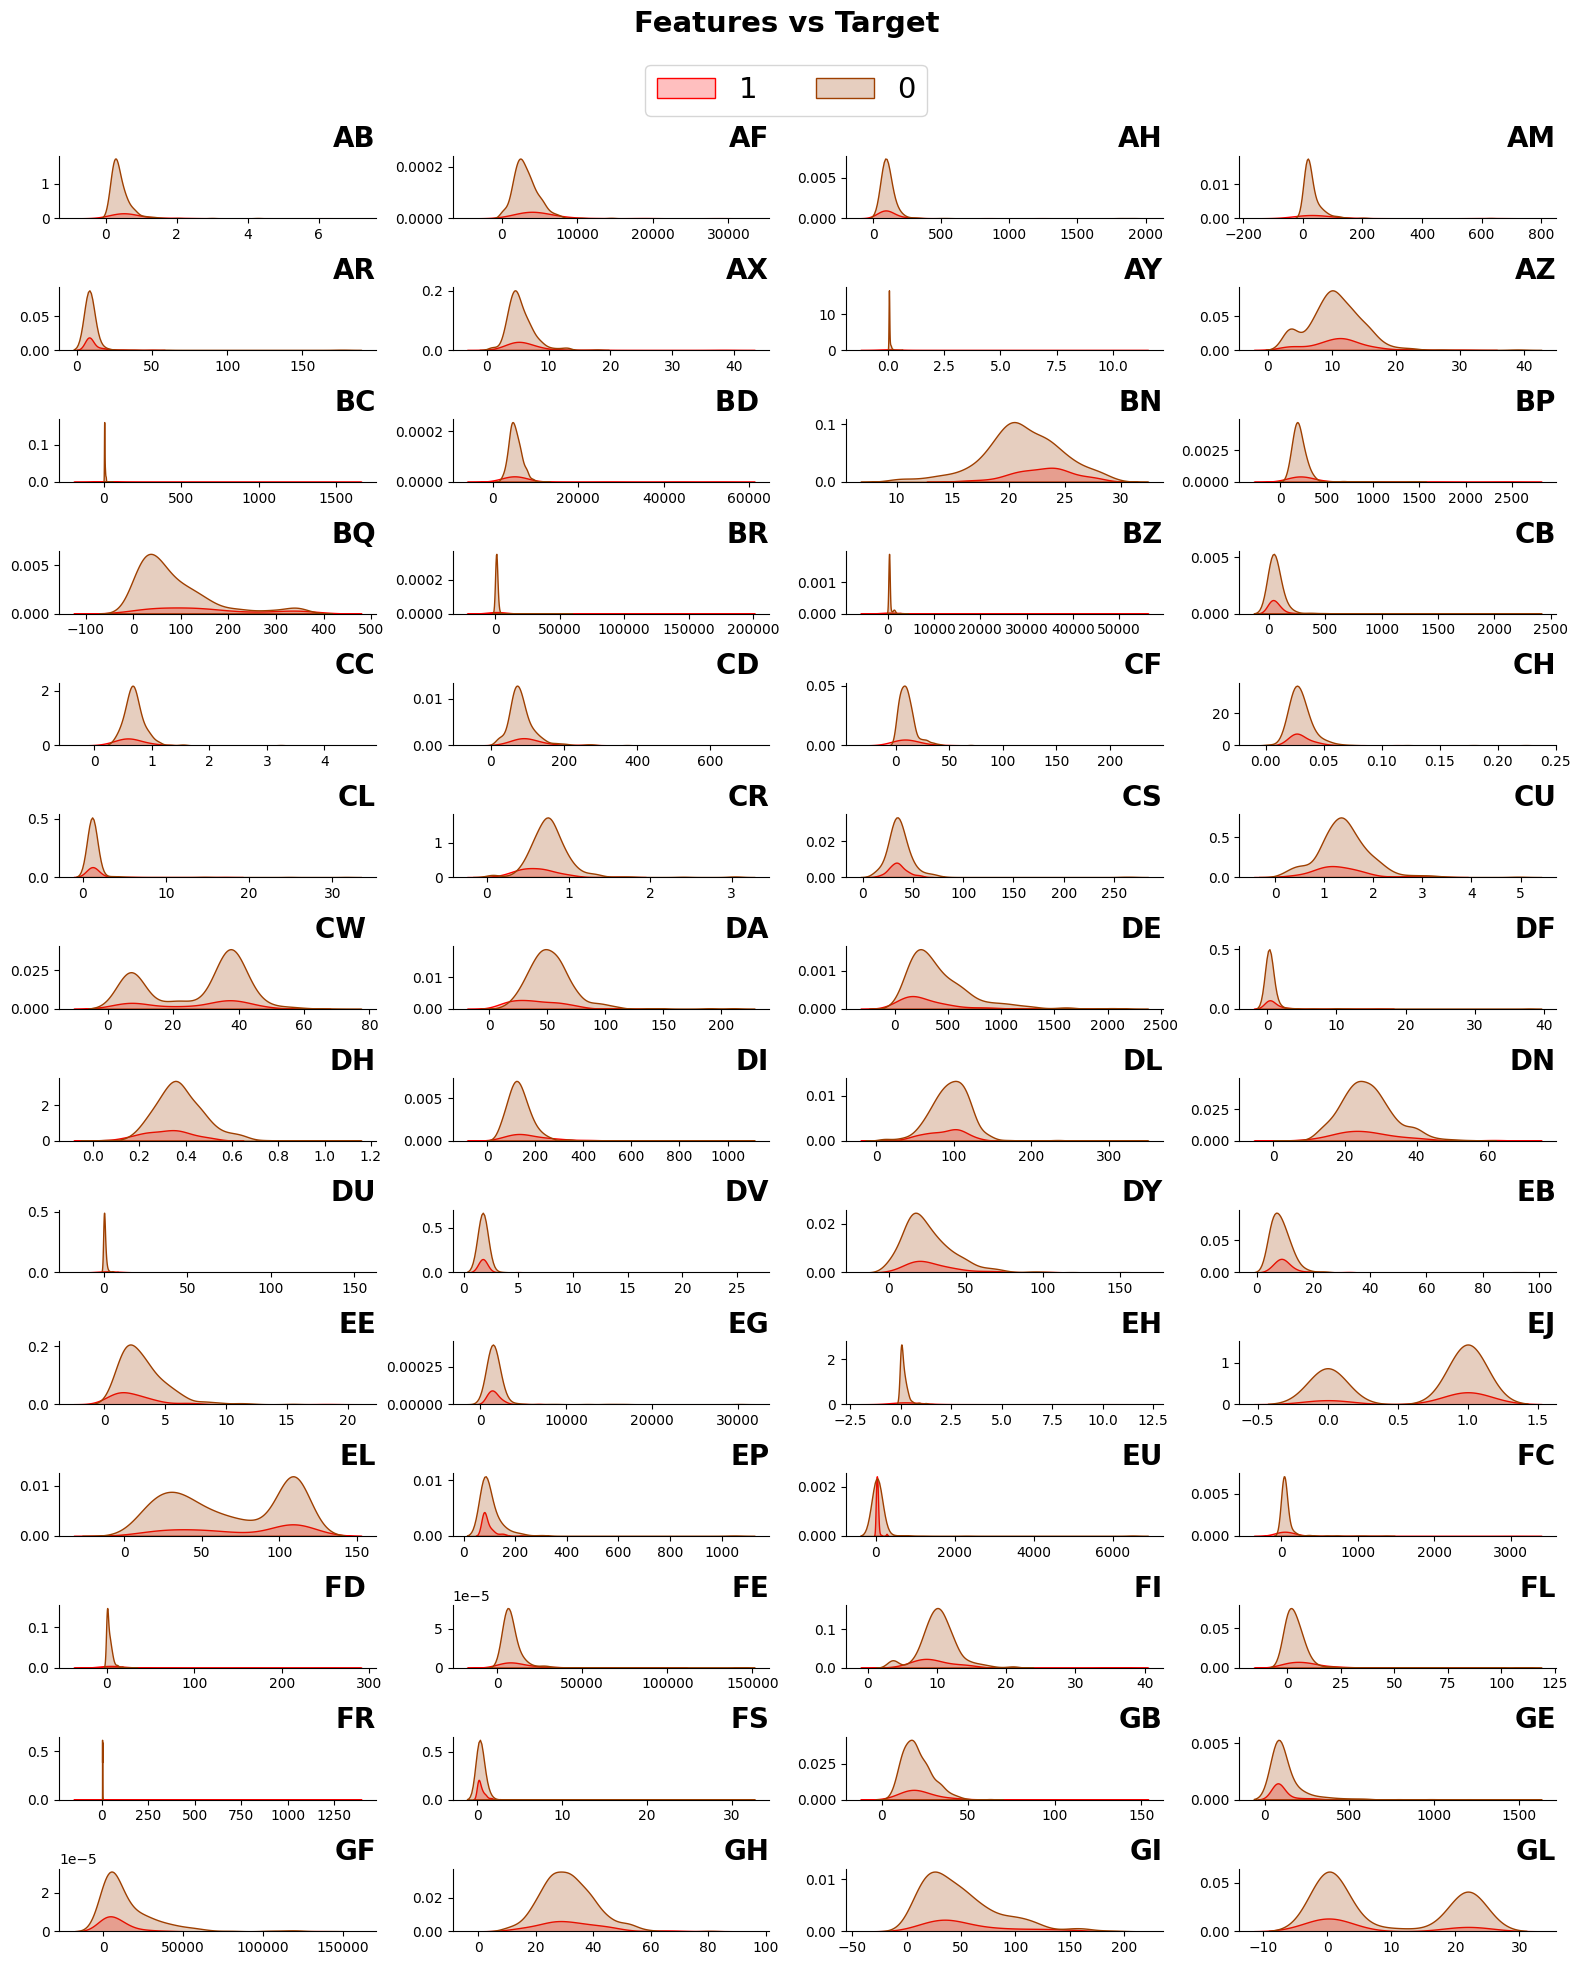

In [10]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(features_train.columns.values.tolist()):  #features_train
    ax = plt.subplot(14,4, idx + 1)
    sns.kdeplot(
        data=df_train, hue='class_label', fill=True,  #df_train
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

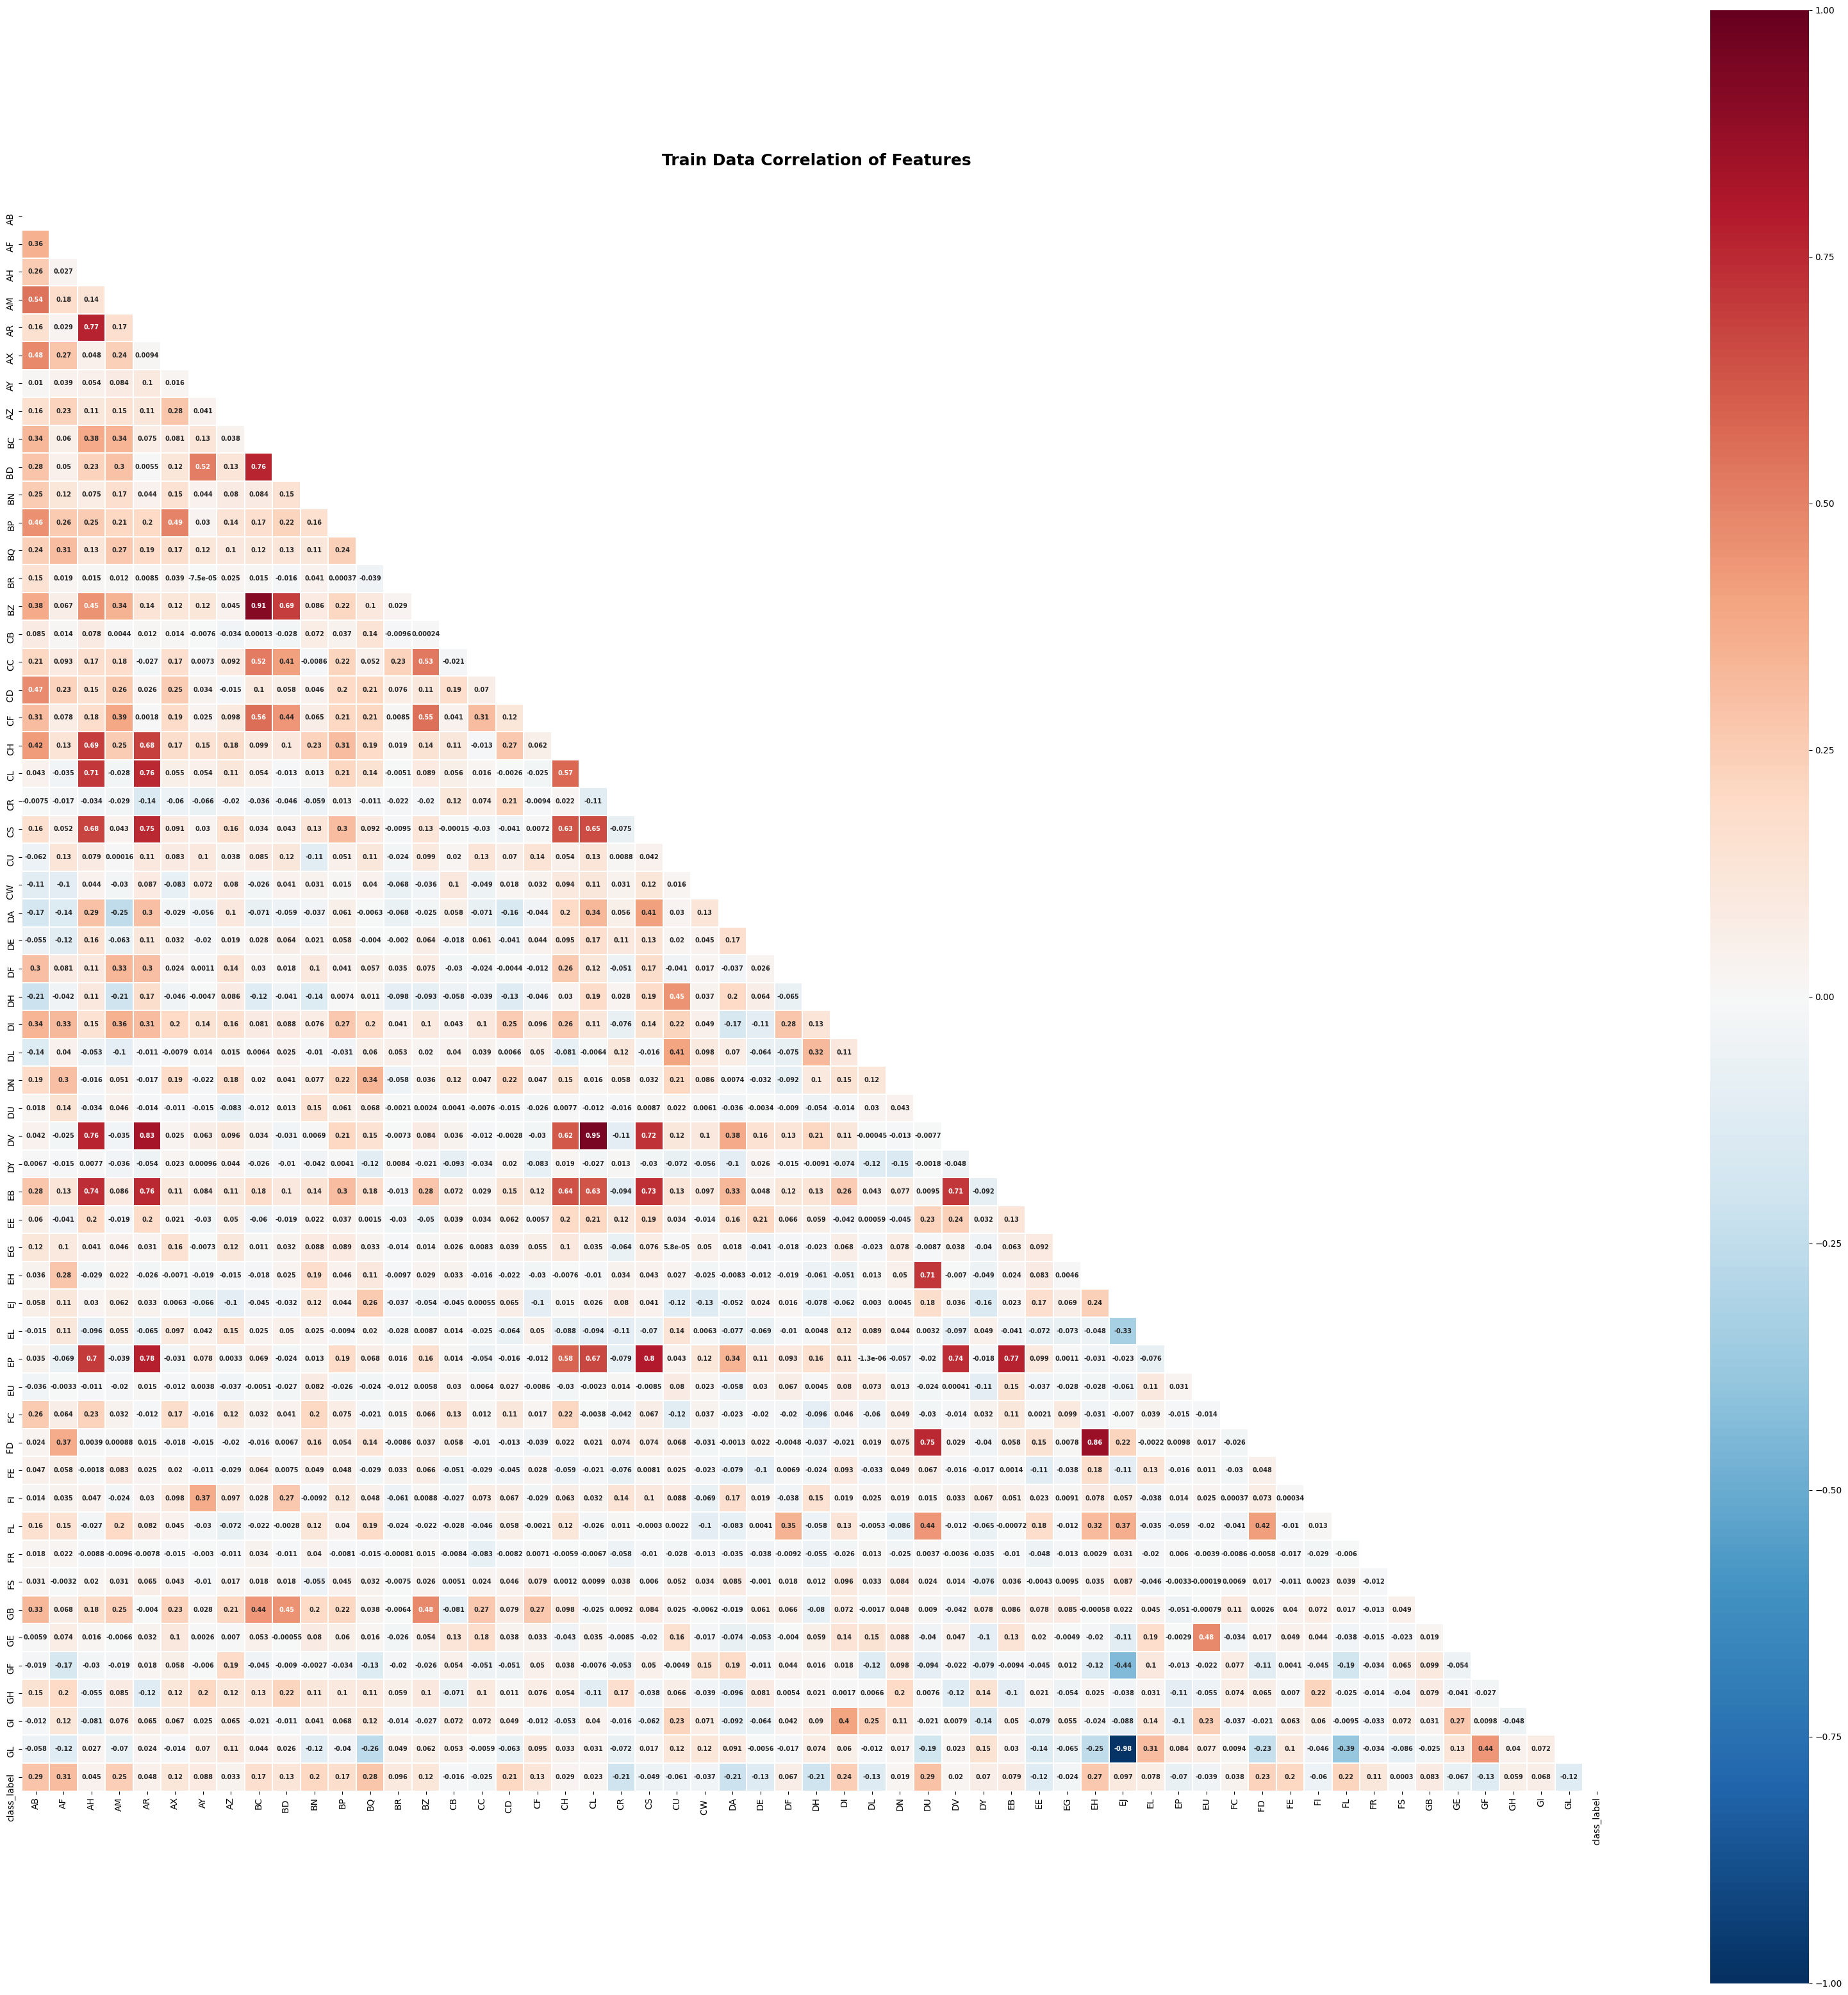

In [11]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())  
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(40, 40))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=18)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 7, "weight": "bold"},
                mask=mask)

plot_heatmap(df_train.iloc[:, 1:], title='Train Data')  #plot df_train X&Y excl. id

### standardisation & PCA/tsne - df_train & df_dev

In [12]:
#standardise features using mean & variance

np.random.seed(1)

sc = StandardScaler()
sc.fit(X_train)  #fit X_train to standadise for both X_train & X_dev
# print("Mean: ", sc.mean_, '\nVariance: ', sc.var_)

X_train_std = sc.transform(X_train)
X_dev_std = sc.transform(X_dev)

In [13]:
#pca to preserve variation in features

np.random.seed(1)

pca = PCA(n_components=30, random_state=0)  #create instance of PCA class using scikit-learn
X_train_pca = pca.fit_transform(X_train_std)
X_dev_pca = pca.transform(X_dev_std)

pd.DataFrame(X_train_pca).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.356750,-1.566680,-2.542966,-1.044026,-0.927896,2.080288,0.588285,-0.236210,-1.080379,-0.067761,...,-0.353253,-0.041827,-1.189753,-0.620386,-1.422628,0.016961,-0.063600,1.374725,-0.302921,0.427277
1,-0.277517,-1.785507,0.333298,2.253863,-2.057368,0.976372,1.382808,-1.013493,0.790998,1.653305,...,0.172359,-0.092004,0.859860,0.345971,-0.644393,-0.766310,-1.422379,-1.189820,0.125519,-0.012092
2,-0.867765,-0.455429,-2.112004,-2.191937,1.259923,0.901037,2.803652,-0.290916,3.238380,-0.405104,...,0.060942,0.059176,0.593719,0.249295,1.607831,1.628416,-0.316785,-0.095904,0.292603,0.242545
3,-0.576318,-0.015096,-2.245415,-0.723436,-0.600312,1.270127,0.284322,-1.102950,-0.840510,0.271055,...,-0.527554,-0.031924,-0.052052,-0.942064,-0.581320,-0.614624,-0.973906,-0.044396,-0.723286,0.666846
4,0.443304,1.677856,-0.128890,-0.831177,1.015491,-1.706775,-0.559104,0.732580,0.374327,-2.000036,...,-0.851696,0.138168,0.308084,-0.392349,0.644645,0.936802,-0.490222,0.313757,0.279203,-0.196677


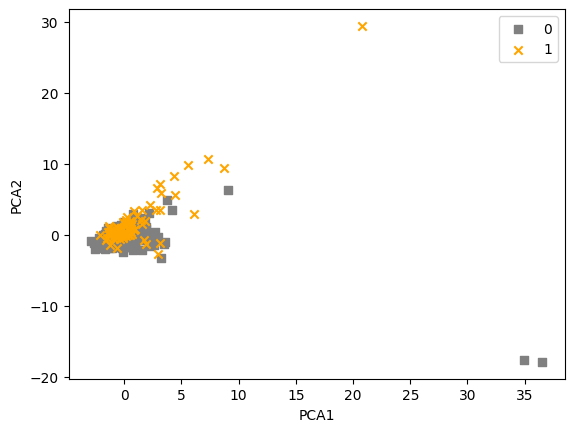

In [14]:
#plot PCA components

colors = ['grey', 'orange']
markers = ['s', 'x']

for class_value, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==class_value, 0],
                X_train_pca[y_train==class_value, 1],
                color = color, label = class_value, marker=marker)

plt.legend(loc='best')
plt.xlabel('PCA1')
plt.ylabel('PCA2');


In [15]:
#tsne to visualise using pca components

np.random.seed(1)

tsne = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne.fit_transform(X_train_pca)
X_dev_tsne= tsne.fit_transform(X_dev_std)


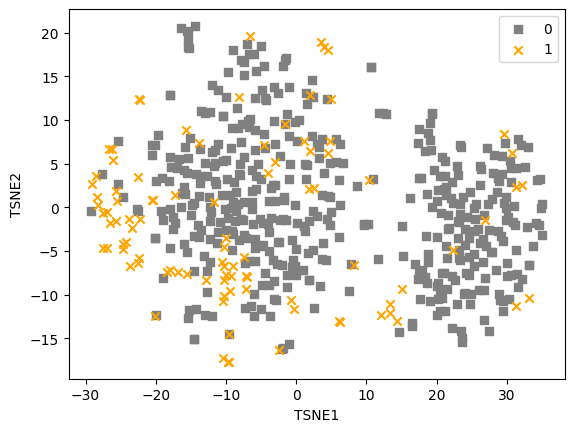

In [16]:
#plot TSNE components

colors = ['grey', 'orange']  #binary classification - only 2 colours
markers = ['s', 'x']

for class_value, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_tsne[y_train==class_value, 0],
                X_train_tsne[y_train==class_value, 1],
                color = color, label = class_value, marker=marker)

plt.legend(loc='best')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

### compute class_weight for imbalanced labels - df_train

In [17]:
#class label overview - imbalanced labels

def class_labels_overview(df, names='class_label'):
      fig2 = px.pie(df, names=names, 
                  height=400, width=600, 
                  hole=0.7, 
                  title='class labels overview',
                        color_discrete_sequence=['#4c78a8', '#72b7b2'])
      fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
      fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                              plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                              title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                              font=dict(size=17, color='#8a8d93'),
                              hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
      fig2.show()

class_labels_overview(df_train)
class_labels_overview(df_dev)

print('total #label_1:', train[train.class_label.eq(1)].shape[0]) 
print('total #label_0:', train[train.class_label.eq(0)].shape[0]) 

total #label_1: 108
total #label_0: 509


In [18]:
#compute class_weight for imbalanced labels - df_train

neg, pos = np.bincount(df_train['class_label'])  #count #samples of each label
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.92


## step4 - fit/predict/evaluate models

### 0. baseline model

In [ ]:
# majority class classifier

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_pca, y_train)
dummy_accuracy = dummy_clf.score(X_dev_pca, y_dev)
print("Development Accuracy with Majority Class Baseline:", dummy_accuracy)


Development Accuracy with Majority Class Baseline: 0.7903225806451613


In [ ]:
# decision stump (max_depth=1) <- BETTER accuracy & harder to beat

from sklearn.tree import DecisionTreeClassifier

stump_clf = DecisionTreeClassifier(max_depth=1, random_state=0)
stump_clf.fit(X_train_pca, y_train)
stump_accuracy = stump_clf.score(X_dev_pca, y_dev)
print("Development Accuracy with Decision Stump:", stump_accuracy)

Development Accuracy with Decision Stump: 0.8548387096774194


### 1. decision tree dt

#### <span style="color:chocolate">dt wo pca</span> 

In [ ]:
#dt1 - use DecisionTreeClassifier from sklearn.tree to draw decision tree 

# dt = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=2)  #only going down 1 depth (ie stump) #dev_accuracy=0.87
# dt = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=2, class_weight='balanced')   #dev_accuracy = 0.73
# dt = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=3)  #dev_accuracy = 0.90
dt = DecisionTreeClassifier(random_state=0, 
                            criterion='gini', 
                            max_depth=4,
                            min_samples_leaf=4,
                            min_samples_split=10,
                            splitter='best')  #best parameters tuned  #dev_accuracy = 0.94
# dt = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=3, class_weight='balanced')   #dev_accuracy = 0.84

dt.fit(X_train, y_train)  #same score using "X_train_std" & X_train_std is used to get X_train_pca used in "dt w pca" below
print('Features:', features_train.columns)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(X_dev, y_dev))

Features: Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')
Feature importances: [0.10463258 0.         0.         0.0127871  0.         0.
 0.         0.         0.15625844 0.         0.         0.
 0.         0.01306224 0.         0.         0.         0.
 0.         0.         0.         0.1224382  0.         0.
 0.         0.         0.         0.         0.05569493 0.
 0.         0.         0.34464631 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.04550091 0.         0.         0.06005139 0.05162004
 0.02954846 0.         0.00375941 0.         0.         0.
 0.         0.        ]
Accuracy

#### <span style="color:green">plot decision tree ----> </span> 

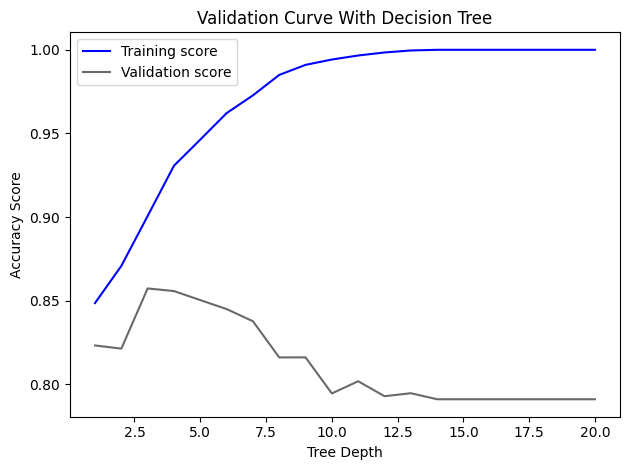

In [20]:
from sklearn.model_selection import validation_curve

# Define the parameter values to evaluate
max_depth = np.arange(1, 21)

# Calculate accuracy on training and validation set using the range of parameter values
train_scores, valid_scores = validation_curve(DecisionTreeClassifier(random_state=0, criterion='gini'), X_train_pca, y_train,
                                              param_name="max_depth", 
                                              param_range=max_depth, cv=10)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot mean accuracy scores for training and validation sets
plt.plot(max_depth, train_mean, label="Training score", color="blue")
plt.plot(max_depth, valid_mean, label="Validation score", color="dimgrey")

# Create plot
plt.title("Validation Curve With Decision Tree")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [21]:
#k-fold validation (cv=10 -> 10-fold validation)

scores = cross_val_score(dt, X_train, y_train, cv=10)
print('Cross-validation scores: {}'.format(scores))
print("Cross-validation score mean w sd: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Cross-validation scores: [0.80357143 0.85714286 0.89285714 0.875      0.83928571 0.89090909
 0.85454545 0.78181818 0.81818182 0.90909091]
Cross-validation score mean w sd: 0.85 (+/- 0.04)


In [22]:
#predict using dev data

y_dev_dt = dt.predict(X_dev)

print('Length y_pred: ', len(y_dev_dt))
print('predictedY:', y_dev_dt, "\n", 'actualY:', y_dev)

Length y_pred:  62
predictedY: [1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0] 
 actualY: [1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


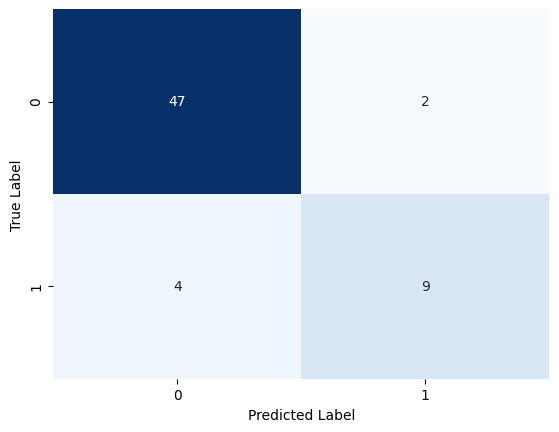

In [23]:
#tf.confusion matrx & sns.heatmap to display confusion matrix

confusion_matrix = tf.math.confusion_matrix(y_dev, y_dev_dt)  

label_names = np.unique(y_train)
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',  
                 xticklabels = label_names, yticklabels = label_names, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [24]:
#precision_score/recall_score/f1_score 

print("tf.keras.metrics")  
p = tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
p.update_state(y_dev, y_dev_dt)  #update_state to update metric scores
print("Precision score: %.3f" %p.result().numpy())

r = tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
r.update_state(y_dev, y_dev_dt)
print("Recall score: %.3f" %r.result().numpy())

print(f"F1 score: {2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())):.3f}")

tf.keras.metrics
Precision score: 0.818
Recall score: 0.692
F1 score: 0.750


ROC AUC:  0.898


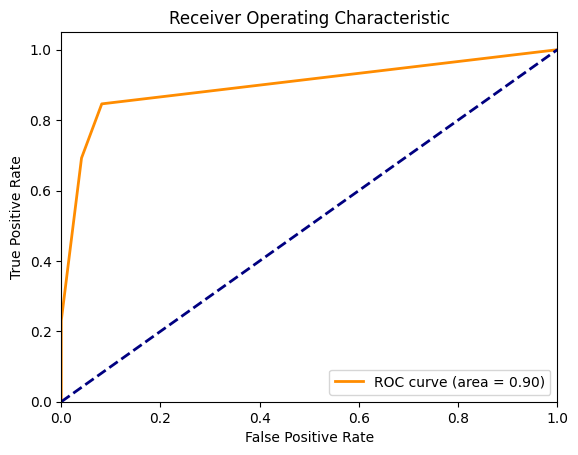

In [25]:
#ROC/AUC from sklearn.metrics 

from sklearn.metrics import roc_curve, auc

y_pred_proba = dt.predict_proba(X_dev)[:, 1]
fpr, tpr, thresholds = roc_curve(y_dev, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC: ", np.round(roc_auc,3))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### dt w pca

In [26]:
#dt2- use DecisionTreeClassifier from sklearn.tree using pca components

dt = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=2)   #dev_accuracy = 0.87
# dt = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=2, class_weight='balanced')   #dev_accuracy = 0.53
# dt = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=3)  #dev_accuracy = 0.84
# dt = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=3, class_weight='balanced')  #dev_accuracy = 0.81
dt.fit(X_train_pca, y_train)

print ('Using a decision stump -- a tree with depth 1:')
print('Features:', features_train.columns)
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(X_dev_pca, y_dev))

Using a decision stump -- a tree with depth 1:
Features: Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')
Feature importances: [0.         0.         0.47560246 0.         0.43499995 0.08939759
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Accuracy: 0.8709677419354839


In [27]:
#predict using dev data

y_dev_dt = dt.predict(X_dev_pca)

print('Length y_pred: ', len(y_dev_dt))
print('predictedY:', y_dev_dt, "\n", 'actualY:', y_dev)

Length y_pred:  62
predictedY: [1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0] 
 actualY: [1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


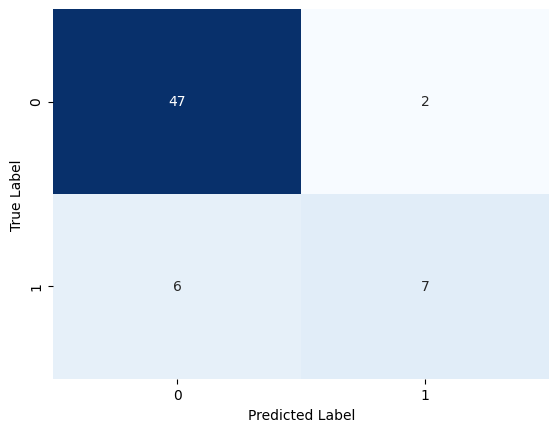

In [28]:
#tf.confusion matrx & sns.heatmap to display confusion matrix

confusion_matrix = tf.math.confusion_matrix(y_dev, y_dev_dt)  

label_names = np.unique(y_train)
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',  
                 xticklabels = label_names, yticklabels = label_names, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [29]:
#precision_score/recall_score/f1_score 

print("tf.keras.metrics")  
p = tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
p.update_state(y_dev, y_dev_dt)  #update_state to update metric scores
print("Precision score: %.3f" %p.result().numpy())

r = tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
r.update_state(y_dev, y_dev_dt)
print("Recall score: %.3f" %r.result().numpy())

print(f"F1 score: {2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())):.3f}")

tf.keras.metrics
Precision score: 0.778
Recall score: 0.538
F1 score: 0.636


ROC AUC:  0.879


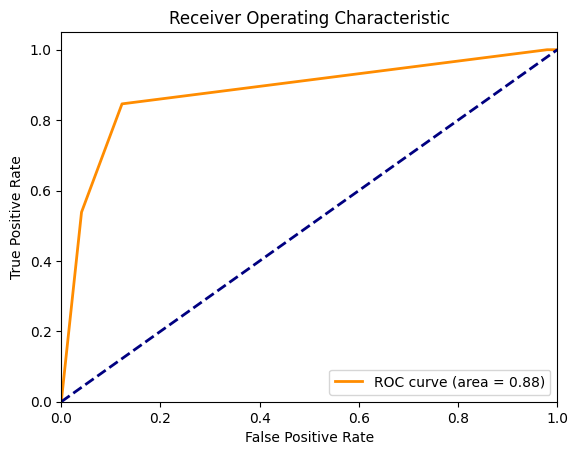

In [30]:
#ROC/AUC from sklearn.metrics 

from sklearn.metrics import roc_curve, auc

y_pred_proba = dt.predict_proba(X_dev_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_dev, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC: ", np.round(roc_auc,3))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### 2. random forest

#### <span style="color:chocolate">rf wo pca</span> 

In [31]:
#rf - randomforest

tf.random.set_seed(1)
np.random.seed(1)

# rf = RandomForestClassifier(random_state=0)  #dev_accuracy = 0.89
# rf = RandomForestClassifier(random_state=0, class_weight=class_weight)  #dev_accuracy = 0.84
# rf = RandomForestClassifier(random_state=0, class_weight='balanced')  #same as above
rf = RandomForestClassifier(random_state=0,
    n_estimators = 200,
    max_depth = 10,
    min_samples_split = 2)  #dev_accuracy = 0.90

rf.fit(X_train, y_train)

print ('Accuracy:', rf.score(X_train, y_train), rf.score(X_dev, y_dev))

Accuracy: 0.9945945945945946 0.9032258064516129


In [32]:
#k-fold validation (cv=10 -> 10-fold validation)

scores = cross_val_score(rf, X_train, y_train, cv=10)
print('Cross-validation scores: {}'.format(scores))
print("Cross-validation score mean w sd: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Cross-validation scores: [0.91071429 0.91071429 0.92857143 0.92857143 0.91071429 0.89090909
 0.94545455 0.94545455 0.89090909 0.89090909]
Cross-validation score mean w sd: 0.92 (+/- 0.02)


In [33]:
#predict using dev data

y_dev_rf = rf.predict(X_dev)

print('Length y_pred: ', len(y_dev_rf))
print('predictedY:', y_dev_rf, "\n", 'actualY:', y_dev)

Length y_pred:  62
predictedY: [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0] 
 actualY: [1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


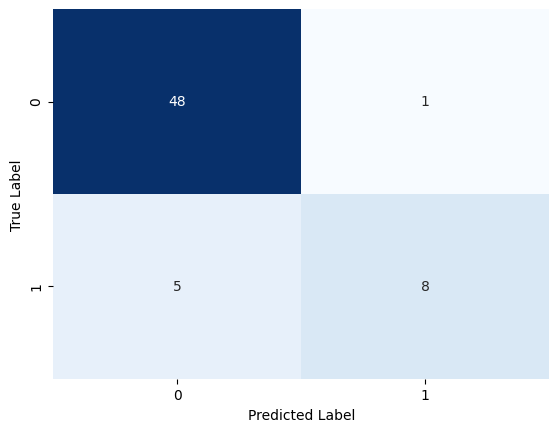

In [34]:
#tf.confusion matrx & sns.heatmap to display confusion matrix

confusion_matrix = tf.math.confusion_matrix(y_dev, y_dev_rf)  

label_names = np.unique(y_train)
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',  
                 xticklabels = label_names, yticklabels = label_names, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [35]:
#precision_score/recall_score/f1_score 

print("tf.keras.metrics")  
p = tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
p.update_state(y_dev, y_dev_rf)  #update_state to update metric scores
print("Precision score: %.3f" %p.result().numpy())

r = tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
r.update_state(y_dev, y_dev_rf)
print("Recall score: %.3f" %r.result().numpy())

print(f"F1 score: {2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())):.3f}")

tf.keras.metrics
Precision score: 0.889
Recall score: 0.615
F1 score: 0.727


ROC AUC:  0.951


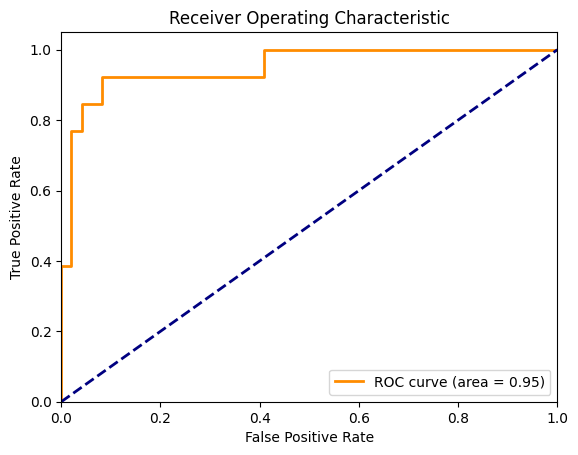

In [36]:
#ROC/AUC from sklearn.metrics 

from sklearn.metrics import roc_curve, auc

y_pred_proba = rf.predict_proba(X_dev)[:, 1]
fpr, tpr, thresholds = roc_curve(y_dev, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC: ", np.round(roc_auc,3))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### rf w pca

In [37]:
#rf - randomforest using pca components 

tf.random.set_seed(1)
np.random.seed(1)

# rf = RandomForestClassifier(random_state=0)  #dev_accuracy = 0.84
rf = RandomForestClassifier(random_state=0, class_weight=class_weight)  #dev_accuracy = 0.85
rf.fit(X_train_pca, y_train)

print ('Accuracy:', rf.score(X_train_pca, y_train), rf.score(X_dev_pca, y_dev))

Accuracy: 1.0 0.8548387096774194


In [38]:
#predict using dev data

y_dev_rf = rf.predict(X_dev_pca)

print('Length y_pred: ', len(y_dev_rf))
print('predictedY:', y_dev_rf, "\n", 'actualY:', y_dev)

Length y_pred:  62
predictedY: [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 actualY: [1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


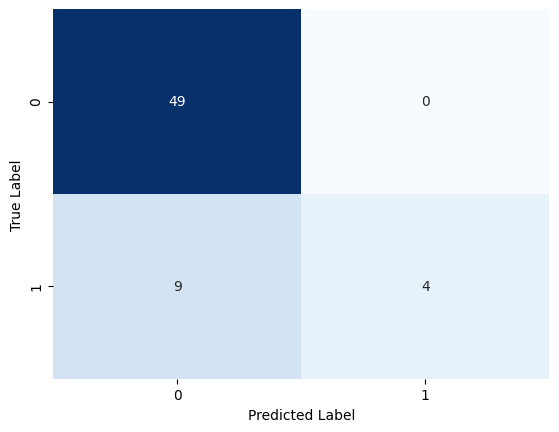

In [39]:
#tf.confusion matrx & sns.heatmap to display confusion matrix

confusion_matrix = tf.math.confusion_matrix(y_dev, y_dev_rf)  

label_names = np.unique(y_train)
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',  
                 xticklabels = label_names, yticklabels = label_names, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [40]:
#precision_score/recall_score/f1_score 

print("tf.keras.metrics")  
p = tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
p.update_state(y_dev, y_dev_rf)  #update_state to update metric scores
print("Precision score: %.3f" %p.result().numpy())

r = tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
r.update_state(y_dev, y_dev_rf)
print("Recall score: %.3f" %r.result().numpy())

print(f"F1 score: {2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())):.3f}")

tf.keras.metrics
Precision score: 1.000
Recall score: 0.308
F1 score: 0.471


ROC AUC:  0.907


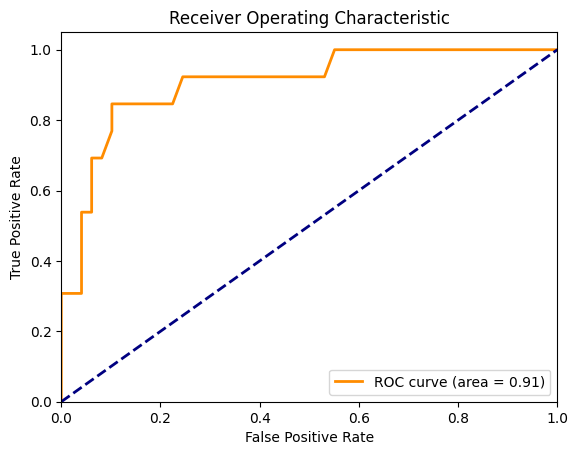

In [41]:
#ROC/AUC from sklearn.metrics 

from sklearn.metrics import roc_curve, auc

y_pred_proba = rf.predict_proba(X_dev_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_dev, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC: ", np.round(roc_auc,3))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### 3. logistic regression

In [42]:
#TF keras api to build logistic regression

def build_model(num_features): 
    tf.keras.backend.clear_session() 
    tf.random.set_seed(1234) 
    
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))  
    model.add(keras.layers.Dense(
        units=1,  #output dim
        use_bias=True,
        activation='sigmoid',
        #kernel_initializer='random_normal',
        #bias_initializer='zeros',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output"
    ))
   
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(), 
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.5), 
        metrics=['accuracy'] 
    )
    return model

log_model = build_model(num_features=X_train_pca.shape[1])  #build TF model - 31 features using pca
log_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [43]:
#fit train & predict dev

tf.random.set_seed(1234)
np.random.seed(1234)

hist = log_model.fit(x=X_train_pca,
                y=y_train,
                batch_size=len(X_train_pca),
                epochs=20,
                verbose=0,
                validation_data=(X_dev_pca, y_dev),
                #validation_split=0.2
)

y_train_log = log_model.predict(x=X_train_pca).flatten()
y_train_log = np.where(y_train_log>=0.5, 1, 0)
y_dev_log = log_model.predict(x=X_dev_pca).flatten()
y_dev_log = np.where(y_dev_log>=0.5, 1, 0)

print('Logistic regression train/dev accuracies %.3f/%.3f' % (accuracy_score(y_train, y_train_log), accuracy_score(y_dev, y_dev_log)))

Logistic regression train/dev accuracies 0.910/0.823


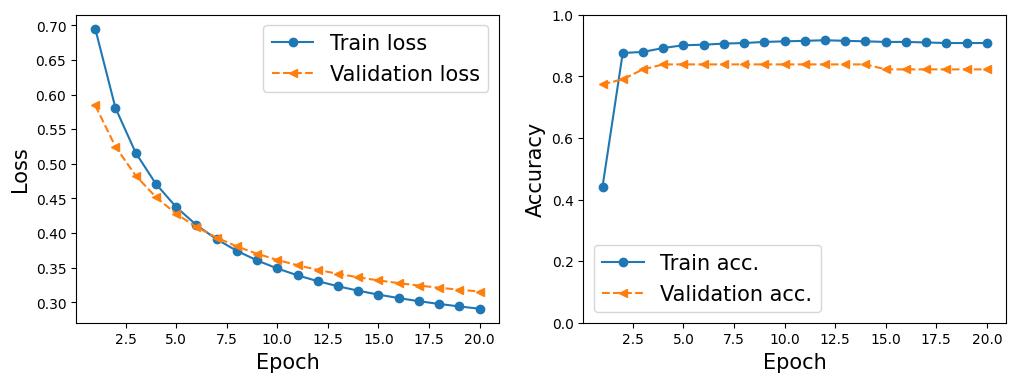

In [44]:
#plot loss & accuracy for train/valid data

hist = hist.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

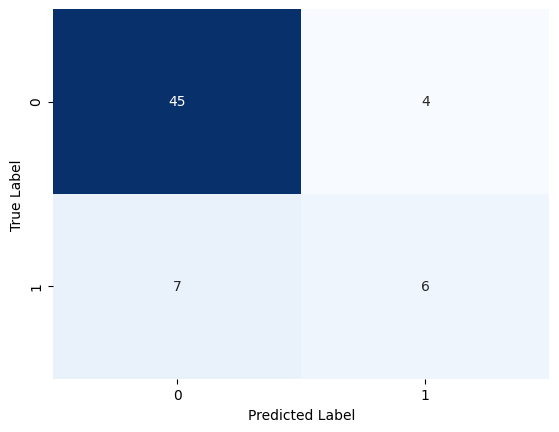

In [45]:
#tf.confusion matrx & sns.heatmap to display confusion matrix

confusion_matrix = tf.math.confusion_matrix(y_dev, y_dev_log)  

label_names = np.unique(y_train)
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',  
                 xticklabels = label_names, yticklabels = label_names, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [46]:
#precision_score/recall_score/f1_score 

print("tf.keras.metrics")  
p = tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
p.update_state(y_dev, y_dev_log)  #update_state to update metric scores
print("Precision score: %.3f" %p.result().numpy())

r = tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
r.update_state(y_dev, y_dev_log)
print("Recall score: %.3f" %r.result().numpy())

print(f"F1 score: {2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())):.3f}")

tf.keras.metrics
Precision score: 0.600
Recall score: 0.462
F1 score: 0.522


ROC AUC:  0.904


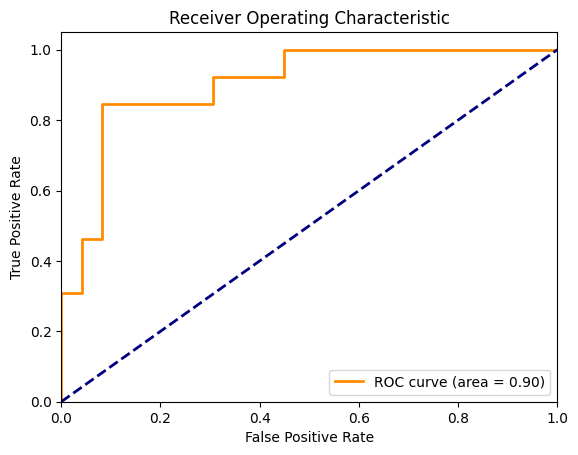

In [47]:
#ROC/AUC from sklearn.metrics 

from sklearn.metrics import roc_curve, auc

y_pred_proba = log_model.predict(X_dev_pca).flatten()
fpr, tpr, thresholds = roc_curve(y_dev, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC: ", np.round(roc_auc,3))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [48]:
#k-fold validation (cv=10 -> 10-fold validation)

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

acc_per_fold = []
loss_per_fold = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []


fold_no = 1
for train, test in kfold.split(X_train_pca, y_train):
    model = build_model(num_features=X_train_pca.shape[1])
    history = model.fit(X_train_pca[train], y_train[train], epochs=20, verbose=0)

    y_pred = model.predict(X_train_pca[test]).flatten()
    y_pred = np.where(y_pred >= 0.5, 1, 0)

    scores = model.evaluate(X_train_pca[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    precision_scores.append(precision_score(y_train[test], y_pred))
    recall_scores.append(recall_score(y_train[test], y_pred))
    f1_scores.append(f1_score(y_train[test], y_pred))
    roc_auc_scores.append(roc_auc_score(y_train[test], y_pred))
    
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
print("Average precision across folds: ", np.mean(precision_scores))
print("Average recall across folds: ", np.mean(recall_scores))
print("Average F1-score across folds: ", np.mean(f1_scores))
print("Average ROC AUC across folds: ", np.mean(roc_auc_scores))

Score for fold 1: loss of 0.40202227234840393; accuracy of 89.18918967247009%
Score for fold 2: loss of 0.22169585525989532; accuracy of 90.99099040031433%
Score for fold 3: loss of 0.29596006870269775; accuracy of 90.99099040031433%
Score for fold 4: loss of 0.38042378425598145; accuracy of 84.68468189239502%
Score for fold 5: loss of 0.3351675271987915; accuracy of 90.09009003639221%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.40202227234840393 - Accuracy: 89.18918967247009%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.22169585525989532 - Accuracy: 90.99099040031433%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.29596006870269775 - Accuracy: 90.99099040031433%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.38042378

### 4. FFNN - to finetune

In [49]:
def build_ffnn_model(num_features):
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)  
    
    model = keras.Sequential()  
    model.add(tf.keras.Input(shape=(num_features,), name='Input')) 
    
    # Hidden layer 1 with 16 units and ReLU activation
    model.add(keras.layers.Dense(
        units=16,
        activation='relu',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Hidden1"
    ))
    
    # Hidden layer 2 with 8 units and ReLU activation
    model.add(keras.layers.Dense(
        units=8,
        activation='relu',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Hidden2"
    ))
    
    model.add(keras.layers.Dropout(0.5))
    
    # Output layer with 1 unit and sigmoid activation for binary classification
    model.add(keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output"
    ))
    
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),  
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  
        metrics=[tf.keras.metrics.BinaryAccuracy()]  
    )
    return model

ffnn_model = build_ffnn_model(num_features=X_train_pca.shape[1])
ffnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 16)                496       
                                                                 
 Hidden2 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 Output (Dense)              (None, 1)                 9         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [50]:
#fit train & predict dev

tf.random.set_seed(1234)  
np.random.seed(1234)

ffnn_model.fit(x=X_train_pca,  
                y=y_train,
                epochs=20,
                verbose=0  
)

y_train_ffnn = ffnn_model.predict(x=X_train_pca).flatten()  
y_train_ffnn = np.where(y_train_ffnn>=0.5, 1, 0)  #choose .5 as threshold to label probs to 0 & 1
y_dev_ffnn = ffnn_model.predict(x=X_dev_pca).flatten()  
y_dev_ffnn = np.where(y_dev_ffnn>=0.5, 1, 0)

print('FFNN train/dev accuracies %.3f/%.3f' % (accuracy_score(y_train, y_train_ffnn), accuracy_score(y_dev, y_dev_ffnn)))

FFNN train/dev accuracies 0.829/0.790


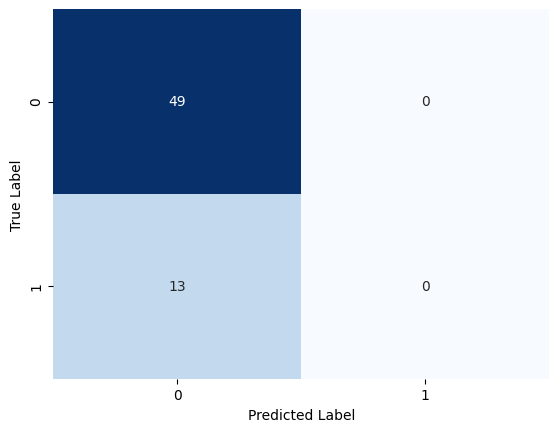

In [51]:
#tf.confusion matrx & sns.heatmap to display confusion matrix

confusion_matrix = tf.math.confusion_matrix(y_dev, y_dev_ffnn)  

label_names = np.unique(y_train)
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',  
                 xticklabels = label_names, yticklabels = label_names, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [52]:
#precision_score/recall_score/f1_score 

print("scikit.metrics")  
print('Precision score: %.3f' % precision_score(y_dev, y_dev_ffnn, average='macro'))
print('Recall score: %.3f' % recall_score(y_dev, y_dev_ffnn, average='macro'))
print('F1 score %.3f' % f1_score(y_dev, y_dev_ffnn, average='macro'))
print()

scikit.metrics
Precision score: 0.395
Recall score: 0.500
F1 score 0.441



c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



ROC AUC:  0.405


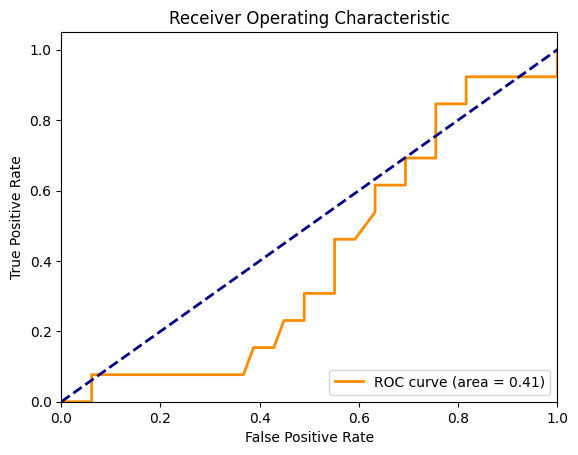

In [53]:
#ROC/AUC from sklearn.metrics 

from sklearn.metrics import roc_curve, auc

y_pred_proba = ffnn_model.predict(X_dev_pca).flatten()
fpr, tpr, thresholds = roc_curve(y_dev, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC: ", np.round(roc_auc,3))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [54]:
#k-fold validation (cv=10 -> 10-fold validation)

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

acc_per_fold = []
loss_per_fold = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []


fold_no = 1
for train, test in kfold.split(X_train_pca, y_train):
    model = build_ffnn_model(num_features=X_train_pca.shape[1])
    history = model.fit(X_train_pca[train], y_train[train], epochs=20, verbose=0)

    y_pred = model.predict(X_train_pca[test]).flatten()
    y_pred = np.where(y_pred >= 0.5, 1, 0)

    scores = model.evaluate(X_train_pca[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    precision_scores.append(precision_score(y_train[test], y_pred))
    recall_scores.append(recall_score(y_train[test], y_pred))
    f1_scores.append(f1_score(y_train[test], y_pred))
    roc_auc_scores.append(roc_auc_score(y_train[test], y_pred))
    
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
print("Average precision across folds: ", np.mean(precision_scores))
print("Average recall across folds: ", np.mean(recall_scores))
print("Average F1-score across folds: ", np.mean(f1_scores))
print("Average ROC AUC across folds: ", np.mean(roc_auc_scores))

Score for fold 1: loss of 0.5281261205673218; binary_accuracy of 82.88288116455078%


c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Score for fold 2: loss of 0.5281549692153931; binary_accuracy of 82.88288116455078%


c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Score for fold 3: loss of 0.528104841709137; binary_accuracy of 82.88288116455078%


c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Score for fold 4: loss of 0.5281412601470947; binary_accuracy of 82.88288116455078%


c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Score for fold 5: loss of 0.528164267539978; binary_accuracy of 82.88288116455078%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5281261205673218 - Accuracy: 82.88288116455078%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5281549692153931 - Accuracy: 82.88288116455078%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.528104841709137 - Accuracy: 82.88288116455078%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5281412601470947 - Accuracy: 82.88288116455078%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.528164267539978 - Accuracy: 82.88288116455078%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 82.8828811645507

c:\Users\lesli\AppData\Local\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

